In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install pyquaternion
# Paper reference:
# https://github.com/hoat23/VisionArtificialAndImageProcessing/blob/master/papers/ColorImageProcessByUsingBQMPThresholdingTechnique.pdf

In [ ]:
#http://kieranwynn.github.io/pyquaternion
from pyquaternion import Quaternion

"""This function convert every element of array to Quaternion"""
def to_quaternion(array_of_elem: np.array) -> np.array:
  # Validate type
  if type(array_of_elem[0]) == Quaternion: 
    return np.array(array_of_elem)
  try:
    array_of_quaterions = list( map(Quaternion, array_of_elem) )
  except:
    print("WARN | to_quaternion\ntypes list: {0}\ntypes elem: {1}".format(type(array_of_elem), type(array_of_elem[0])) )
    array_of_quaterions = array_of_elem
  finally:
    return np.array(array_of_quaterions)

"""This function compute the first moment of array of Quaternions"""
def first_moment(array_of_elem: np.array) -> Quaternion:
  array_of_elem = to_quaternion(array_of_elem)
  q = np.sum(array_of_elem, axis=0) / len(array_of_elem)
  return q

"""This function compute the second moment of array of Quaternions"""
def second_moment(array_of_elem: np.array) -> Quaternion:
  array_of_elem = to_quaternion(array_of_elem)
  tmp_vectors = list( map(lambda q:q*q.conjugate, array_of_elem) )
  return first_moment(tmp_vectors)

"""This function compute the third moment of array of Quaternions"""
def third_moment(array_of_elem: np.array) -> Quaternion:
  array_of_elem = to_quaternion(array_of_elem)
  tmp_vectors = list( map(lambda q:q*q.conjugate*q , array_of_elem) )
  return first_moment(tmp_vectors)

"""This function compute the 1,2 and 3 moment of array of Quaternions"""
def compute_moments(array_of_elem: np.array) -> np.array:
  m1 = first_moment(array_of_elem)
  m2 = second_moment(array_of_elem)
  m3 = third_moment(array_of_elem)
  return [m1,m2,m3]

In [ ]:
import math

"""This function compute the z0 and z1"""
def calculate_z(M1: Quaternion, M2:Quaternion, M3:Quaternion):
  C1 = (M3 - M1*M2)/(M1*M1.conjugate - M2)
  C0 = -(M1.conjugate*C1 + M2)
  # Extration of component
  c10, c11, c12, c13 = C1
  c00,   _,   _,   _ = C0
  # Computing temporal variables
  pow_c13c12 = c13*c13 + c12*c12
  U = (c10*c12 - c11*c13)/pow_c13c12
  V = (c11*c12 + c10*c13)/pow_c13c12
  W = (c11*V + c10*U + c12)/(c10*V - c11*U + c13)
  a1 = ( 1 + W*W )*( 1 + U*U + V*V)
  a2 = W * ( U*c10 + V*c11 + c12) - U*c11 + V*c10 + c13
  # Solving a1^2 * z3^2 + a2*z3 + c00 = 0
  d = math.sqrt( a2*a2 - 4*a1*c00 ) 
  z03 = - (a2 - d) / (2*a1)
  z13 = - (a2 + d) / (2*a1)
  z02 = W * z03
  z12 = W * z13
  z01 = (W*V - U) * z03
  z11 = (W*V - U) * z13
  z00 = (W*U + V) * z03
  z10 = (W*U + V) * z13
  Z0 = Quaternion(z00, z01, z02, z03)
  Z1 = Quaternion(z10, z11, z12, z13)
  return Z1, Z0

In [ ]:
def decision_boundary(Z0:Quaternion, Z1:Quaternion):
  z10, z11, z12, z13 = Z1
  z00, z01, z02, z03 = Z0
  Z0Z0 = z00*z00 + z01*z01 + z02*z02 + z03*z03
  Z1Z1 = z10*z10 + z11*z11 + z12*z12 + z13*z13
  s = (Z0Z0-Z1Z1)/(2*(z00-z10))
  t1 = (z01 - z11)/(z00-z10)
  t2 = (z02 - z12)/(z00-z10)
  t3 = (z03 - z13)/(z00-z10)
  return s,t1,t2,t3

def clasification(Q:np.array, Z0:Quaternion , Z1:Quaternion):
  s, t1, t2, t3 = decision_boundary(Z0,Z1)
  bitmap = []; list_p0 = []; list_p1 = []
  for one_quaternio in Q:
    q0, q1, q2, q3 = one_quaternio
    q_diff = q0 - (s - t1*q1 - t2*q2 - t3*q3)
    if q_diff >= 0:
      bitmap.append(1)
      list_p1.append(one_quaternio)
    else:
      bitmap.append(0)
      list_p0.append(one_quaternio)
  array_z0 = np.array( list_p0 )
  array_z1 = np.array( list_p1 )
  return np.array(bitmap), [array_z0, array_z1]

In [ ]:
def BQMP_thresholding(Q_data: np.array):
  Q = to_quaternion(Q_data)
  moments = [M1, M2, M3] = compute_moments(Q)
  # Doing M1 = 0, by preserve moments
  Q_ = Q - M1
  M1_, M2_, M3_ = compute_moments(Q_)
  #print("M1  : {0} \n M2  : {1} \n M3  : {2}".format(M1, M2, M3) )
  #print("M1_ : {0} \n M2_ : {1} \n M3_ : {2}".format(M1_, M2_, M3_) )
  # Calculate Z0 & Z1
  Z1_, Z0_ = calculate_z(M1_,M2_,M3_)
  #print("Z1_ : {0} \n Z0_ : {1}".format(Z1_, Z0_) )
  # Real value Z0 & Z1
  Z1 = Z1_ + M1
  Z0 = Z0_ + M1
  # Approximate to p0 & p1
  array_bitmap, [array_z0,array_z1] = clasification(Q,Z0,Z1)
  return Z1, Z0, array_bitmap, [array_z0,array_z1], moments

In [ ]:
Q =[[  8, 12, 19,  9], [  7, 13, 14, 13], [ 11, 14, 19, 10], [ 13, 10, 16,  9],
    [ 80,117, 53, 98], [ 88,118, 63,103], [105,106, 88, 89], [109,117, 71,106],
    [ 90,112, 49, 92], [ 99,113, 34, 84], [ 10, 17, 17, 18], [113,115, 77,117],
    [100,117, 34, 89], [102,115, 43, 93], [ 12, 13, 12, 17], [110,112, 70,122]]
Q = np.array(Q)
print("Q      : \n {0}".format(Q))
Z1, Z0, array_bitmap, [array_z0,array_z1], moments = BQMP_thresholding(Q)
p0 = len(array_z0) / (len(array_z1) + len(array_z0))
p1 = len(array_z1) / (len(array_z1) + len(array_z0))
bitmap = np.reshape(array_bitmap, (4, 4))
print("\n")
print("M1     : ", moments[0])
print("M2     : ", moments[1])
print("M3     : ", moments[2])
print("\n")
print("Z0     : ", Z0)
print("Z1     : ", Z1)
print("\n")
print("p0     : ", p0)
print("p1     : ", p1)
print("\n")
print("bitmap : \n", bitmap)

Q      : 
 [[  8  12  19   9]
 [  7  13  14  13]
 [ 11  14  19  10]
 [ 13  10  16   9]
 [ 80 117  53  98]
 [ 88 118  63 103]
 [105 106  88  89]
 [109 117  71 106]
 [ 90 112  49  92]
 [ 99 113  34  84]
 [ 10  17  17  18]
 [113 115  77 117]
 [100 117  34  89]
 [102 115  43  93]
 [ 12  13  12  17]
 [110 112  70 122]]


M1     :  66.062 +76.312i +42.438j +66.812k
M2     :  23256.875 +0.000i +0.000j +0.000k
M3     :  2316254.250 +2627624.812i +1386238.938j +2319902.000k


Z0     :  101.780 +119.593i +56.310j +100.844k
Z1     :  12.050 +10.864i +21.460j +15.351k


p0     :  0.375
p1     :  0.625


bitmap : 
 [[0 0 0 0]
 [1 1 1 1]
 [1 1 0 1]
 [1 1 0 1]]


In [ ]:
# Paper reference:
# file:///C:/Users/LENOVO/Downloads/papers/Color-Texture_Pattern_Classification_Using_Global.pdf

# Defining colors 
S = [0,   0, 255, 255]
B = [0,   0,   0, 255]
R = [0, 255,   0,   0]
G = [0,   0, 255,   0]
print("Defining colors ")
print("Sky  : {0}".format(S))
print("Blue : {0}".format(B))
print("Red  : {0}".format(R))
print("Green: {0}".format(G))
print("\n")
Q_data = [  R, G, S,
            R, S, S,
            B, B, B]
Q_data = np.array(Q_data)
Q = to_quaternion(Q_data)
M1, M2, M3 = compute_moments(Q)
print(" M1  : {0} \n M2  : {1} \n M3  : {2}\n".format(M1, M2, M3) )
Q_ = Q - M1
M1_, M2_, M3_ = compute_moments(Q_)
print(" M1_ : {0} \n M2_ : {1} \n M3_ : {2}\n".format(M1_, M2_, M3_) )
Z1_, Z0_ = calculate_z(M1_,M2_,M3_)
print(" Z1_ : {0} \n Z0_ : {1}\n".format(Z1_, Z0_) )
# Real value Z0 & Z1
Z1 = Z1_ + M1
Z0 = Z0_ + M1
print(" Z1  : {0} \n Z0  : {1}\n".format(Z1, Z0) )
# Approximate to p0 & p1
bitmap, [array_z0, array_z1] = clasification(Q,Z0,Z1)
c0 = len(array_z0); c1 = len(array_z1)
z1 = np.sum(array_z1) / c1
z0 = np.sum(array_z0) / c0
print("z averange")
print(" z1  : {1} x ({0}) \n z0  : {3} x ({2})\n".format(z1, c1 , z0, c0) )

Defining colors 
Sky  : [0, 0, 255, 255]
Blue : [0, 0, 0, 255]
Red  : [0, 255, 0, 0]
Green: [0, 0, 255, 0]


 M1  : +0.000 +56.667i +113.333j +170.000k 
 M2  : +86700.000 +0.000i +0.000j +0.000k 
 M3  : +0.000 +3684750.000i +12896625.000j +16581375.000k

 M1_ : +0.000 +0.000i +0.000j +0.000k 
 M2_ : +41744.444 +0.000i +0.000j +0.000k 
 M3_ : +0.000 +2229046.296i -659615.741j -2524736.111k

 Z1_ : -0.000 +162.061i -47.957j -183.559k 
 Z0_ : +0.000 -108.664i +32.156j +123.078k

 Z1  : -0.000 +218.728i +65.376j -13.559k 
 Z0  : +0.000 -51.997i +145.489j +293.078k

z averange
 z1  : 6 x (+0.000 +0.000i +127.500j +255.000k) 
 z0  : 3 x (+0.000 +170.000i +85.000j +0.000k)



In [ ]:
Q = array_z0
print("Q:\n", Q, "\n")
M1, M2, M3 = compute_moments(Q)
print(" M1  : {0} \n M2  : {1} \n M3  : {2}\n".format(M1, M2, M3) )
Q_ = Q - M1
M1_, M2_, M3_ = compute_moments(Q_)
print(" M1_ : {0} \n M2_ : {1} \n M3_ : {2}\n".format(M1_, M2_, M3_) )
Z1_, Z0_ = calculate_z(M1_,M2_,M3_)
print(" Z1_ : {0} \n Z0_ : {1}\n".format(Z1_, Z0_) )
# Real value Z0 & Z1
Z1 = Z1_ + M1
Z0 = Z0_ + M1
print(" Z1  : {0} \n Z0  : {1}\n".format(Z1, Z0) )
# Approximate to p0 & p1
bitmap, [array_z0, array_z1] = clasification(Q,Z0,Z1)
c0 = len(array_z0); c1 = len(array_z1)
z1 = np.sum(array_z1) / c1
z0 = np.sum(array_z0) / c0
print("z averange")
print(" z1  : {1} x ({0}) \n z0  : {3} x ({2})\n".format(z1, c1 , z0, c0) )

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
#from utils_imgprocessing import *

directory_work = "/content/drive/My Drive/Work/01_ProyectoARIA" #ScrappingWeb.ipynb
os.chdir(directory_work)

def load_code_from_url(url_path):
  code_str = urlopen(url_path).read()
  code_str = code_str.decode('utf-8')
  exec(code_str)
  return code_str
code_str = load_code_from_url("https://raw.githubusercontent.com/hoat23/VisionArtificialAndImageProcessing/master/bin/utils_imgprocessing.py")
exec(code_str)
#img = load_image_from_url("https://github.com/hoat23/VisionArtificialAndImageProcessing/blob/master/img/brodatz_database/D104_COLORED.tif")
#!wget https://github.com/hoat23/VisionArtificialAndImageProcessing/blob/master/img/brodatz_database/D104_COLORED.tif -O "D104_COLORED.tif"

Mounted at /content/drive/


In [ ]:
!pip install ipyplot
from PIL import Image
from urllib.request import urlopen
import requests as req
import ipyplot


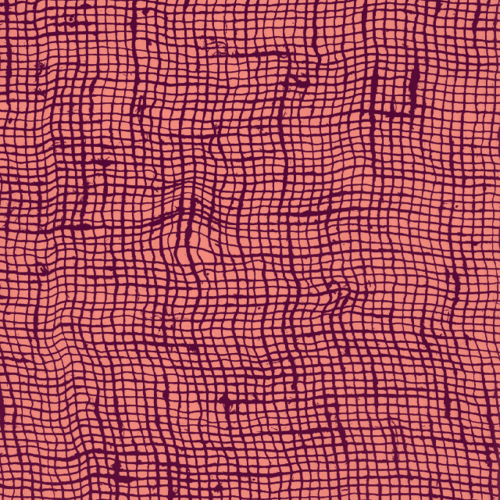

In [ ]:
URL_IMG = '/content/drive/My Drive/Work/01_ProyectoARIA/images/TEXTURE_DATABASE/D104_COLORED.tif'
ipyplot.plot_images([URL_IMG],img_width=250, force_b64=True)

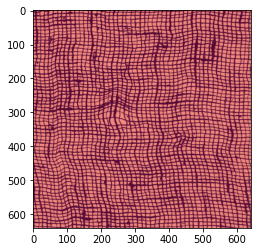

In [ ]:
img = cv2.imread(URL_IMG, cv2.IMREAD_COLOR)
#img_float = np.uint8(img) #"int32") #"uint8")
plot_img(img)

In [ ]:
#fft = np.fft.fft(img)
#tmp =  map(lambda row: map(lambda pix:(sum(pix.real), pix[0].imag, pix[1].imag, pix[2].imag), row) , fft)
def image2quaternion(img):
  r, g, b = cv2.split(img)
  width, hight, _ = img.shape
  #img_quaternion = np.zeros_like((width,hight))
  list_quaternion = []
  for x in np.arange(0,width):
    for y in np.arange(0,hight):
      q = Quaternion( [ 0, r[x,y], g[x,y], b[x,y] ])
      #img_quaternion[x,y] = q
      #q = np.array( [r[x,y], g[x,y], b[x,y], 0] )
      list_quaternion.append(q)
  return list_quaternion
img_quaternion = image2quaternion(img)

In [ ]:
img_Q = to_quaternion(img_quaternion)
M1, M2, M3 = compute_moments(img_Q)
print(" M1  : {0} \n M2  : {1} \n M3  : {2}".format(M1, M2, M3) )

 M1  : +0.000 +91.649i +78.158j +169.410k 
 M2  : +51134.014 +0.000i +0.000j +0.000k 
 M3  : +0.000 +91.649i +78.158j +169.410k


In [ ]:
img_Q_ = img_Q - M1
M1_, M2_, M3_ = compute_moments(img_Q_)
print(" M1_ : {0} \n M2_ : {1} \n M3_ : {2}".format(M1_, M2_, M3_) )

 M1_ : +0.000 +0.000i +0.000j +0.000k 
 M2_ : +7926.284 +0.000i +0.000j +0.000k 
 M3_ : +0.000 -35052.188i -64538.959j -76725.715k


In [ ]:
Z1_, Z0_ = calculate_z(M1_,M2_,M3_)
print("Z0_    : ", Z0_)
print("Z1_    : ", Z1_)
print("\n")
# Real value Z0 & Z1
Z1 = Z1_ + M1
Z0 = Z0_ + M1
print("Z0     : ", Z0)
print("Z1     : ", Z1)
print("\n")

Z0_    :  0.000 +27.254i +50.181j +59.656k
Z1_    :  -0.000 -31.676i -58.323j -69.336k


Z0     :  0.000 +118.903i +128.338j +229.066k
Z1     :  0.000 +59.973i +19.835j +100.074k




In [ ]:
# Approximate to p0 & p1
array_bitmap, [array_z0, array_z1] = clasification(img_Q_,Z0_,Z1_)
c0 = len(array_z0); c1 = len(array_z1)
print("total {0} == {1}".format(len(img_Q_), c0+c1))
print("c0     : ", c0)
print("c1     : ", c1)
z1 = np.sum((array_z1+M1)) / c1
z0 = np.sum((array_z0+M1)) / c0
p0 = c0 / (c0 + c1)
p1 = c1 / (c0 + c1)
print("p0     : ", p0)
print("p1     : ", p1)
print("z averange")
print(" z1  : {1} x ({0}) \n z0  : {3} x ({2})\n".format(z1, c1 , z0, c0) )
#bitmap = np.reshape(bitmap, (4, 4))
#print("bitmap : \n", bitmap)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


total 409600 == 409600
c0     :  196516
c1     :  213084
p0     :  0.479775390625
p1     :  0.520224609375
z averange
 z1  : 213084 x (+0.000 +118.676i +127.980j +228.521k) 
 z0  : 196516 x (+0.000 +62.343i +24.134j +105.314k)



In [ ]:
# Approximate to p0 & p1
array_bitmap, p0, p1 = clasification(img_Q,Z0,Z1)